In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


from sklearn import metrics, preprocessing

import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import Lasso, Ridge, SGDRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

import seaborn as sb

In [12]:
df = pd.read_csv("chrolophylldata_with_geocoding_and_weather.csv")
cols = ['Date2','Latitude','Longitude','Chlorophyll', 'pH', 'Temperature', 'P', 'DissolvedOxygen', 'ElecticalConductivity','Turbidity','N']
data = df[cols]
data = data.dropna()

#data=data[(data["Chlorophyll"]<=100) & (data["Chlorophyll"]>=20)]
data=data[data["Chlorophyll"]<=100]

col = data.pop("Chlorophyll")
data.insert(0, col.name, col)   

#data = data.query('Chlorophyll < Chlorophyll.quantile(.75)')
#data = data.query('Chlorophyll > Chlorophyll.quantile(.25)')

#### 2.0 Random tree

##### Scaling

In [13]:
scaler = preprocessing.MinMaxScaler()
d = scaler.fit_transform(data)
scaled_data = pd.DataFrame(d, columns=data.columns)

#scaled_data = scaled_data.query('Chlorophyll < Chlorophyll.quantile(.75)')
#scaled_data = scaled_data.query('Chlorophyll > Chlorophyll.quantile(.25)')

print(scaled_data)
print(scaled_data.shape)
scaled_data.describe()

scaled_data=data.copy()


     Chlorophyll     Date2  Latitude  Longitude        pH  Temperature   
0       0.238790  0.677612  0.749204   0.557730  0.728155     0.265217  \
1       0.489051  0.677612  0.710531   1.000000  0.825243     0.773913   
2       0.032325  0.677612  0.578933   0.985879  0.436893     0.739130   
3       0.259645  0.695522  1.000000   0.783655  0.339806     0.782609   
4       0.014599  0.298507  1.000000   0.783655  0.048544     0.269565   
..           ...       ...       ...        ...       ...          ...   
257     0.005214  0.629851  0.956697   0.052265  0.307443     0.778261   
258     0.040667  0.901493  0.956697   0.052265  0.417476     0.273913   
259     0.014599  0.083582  0.956697   0.052265  0.291262     0.091304   
260     0.078206  0.376119  0.956697   0.052265  0.404531     0.621739   
261     0.103233  0.626866  0.956697   0.052265  0.889968     0.800000   

            P  DissolvedOxygen  ElecticalConductivity  Turbidity         N  
0    0.034247         0.439560    

##### Splitting Data

In [14]:
y=scaled_data["Chlorophyll"]
X_train,X_test,Y_train,Y_test = train_test_split(
    scaled_data[['Date2', 'pH','Latitude','Longitude', 'Temperature', 'P', 'DissolvedOxygen', 'ElecticalConductivity','Turbidity','N']],
    y,
    test_size=0.2,
    random_state=9    
    )
print (f"Training Set Size: {X_train.shape[0]}")
print (f"Test Set Size: {X_test.shape[0]}")

Training Set Size: 209
Test Set Size: 53


#### Random forest

In [15]:
rf = RandomForestRegressor(n_estimators=10, random_state=42, max_depth=4)
pr=rf.fit(X_train,Y_train)
print(f'R-Squared (train): {rf.score(X_train, Y_train)}')
print(f'R-Squared (test): {rf.score(X_test, Y_test)}')


R-Squared (train): 0.8810487479949972
R-Squared (test): 0.6888625156260318


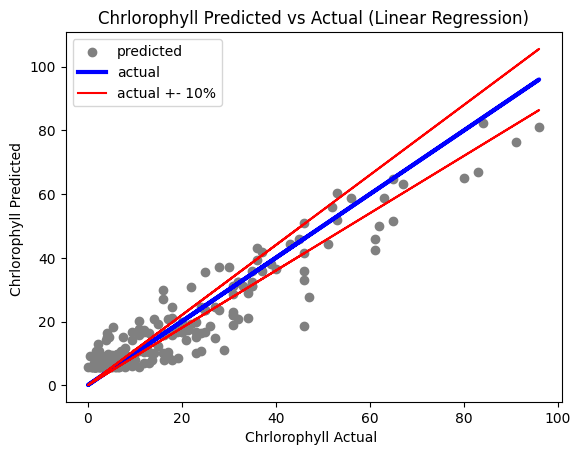

In [16]:
Y_pred = rf.predict(X_train )
plt.scatter(Y_train,Y_pred,color='gray', label='predicted')
plt.plot(Y_train,Y_train,color='blue', linewidth=3, label='actual')
plt.plot(Y_train,Y_train*1.1,color='red', linewidth=1.5, label='actual +- 10%')
plt.plot(Y_train,Y_train*0.9,color='red', linewidth=1.5 )
plt.title('Chrlorophyll Predicted vs Actual (Linear Regression)')  
plt.xlabel('Chrlorophyll Actual ')  
plt.ylabel('Chrlorophyll Predicted ')  
plt.legend(loc="upper left")

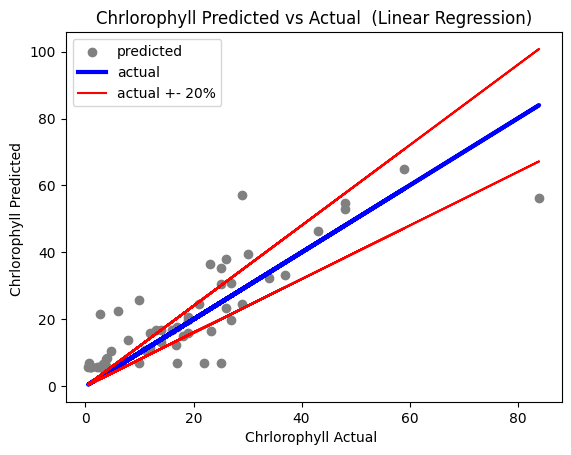

In [17]:
Y_pred = rf.predict(X_test )
plt.scatter(Y_test,Y_pred,color='gray', label='predicted')
plt.plot(Y_test,Y_test,color='blue', linewidth=3, label='actual')
plt.plot(Y_test,Y_test*1.2,color='red', linewidth=1.5, label='actual +- 20%')
plt.plot(Y_test,Y_test*0.8,color='red', linewidth=1.5 )
plt.title('Chrlorophyll Predicted vs Actual  (Linear Regression)')  
plt.xlabel('Chrlorophyll Actual ')  
plt.ylabel('Chrlorophyll Predicted ')  
plt.legend(loc="upper left")

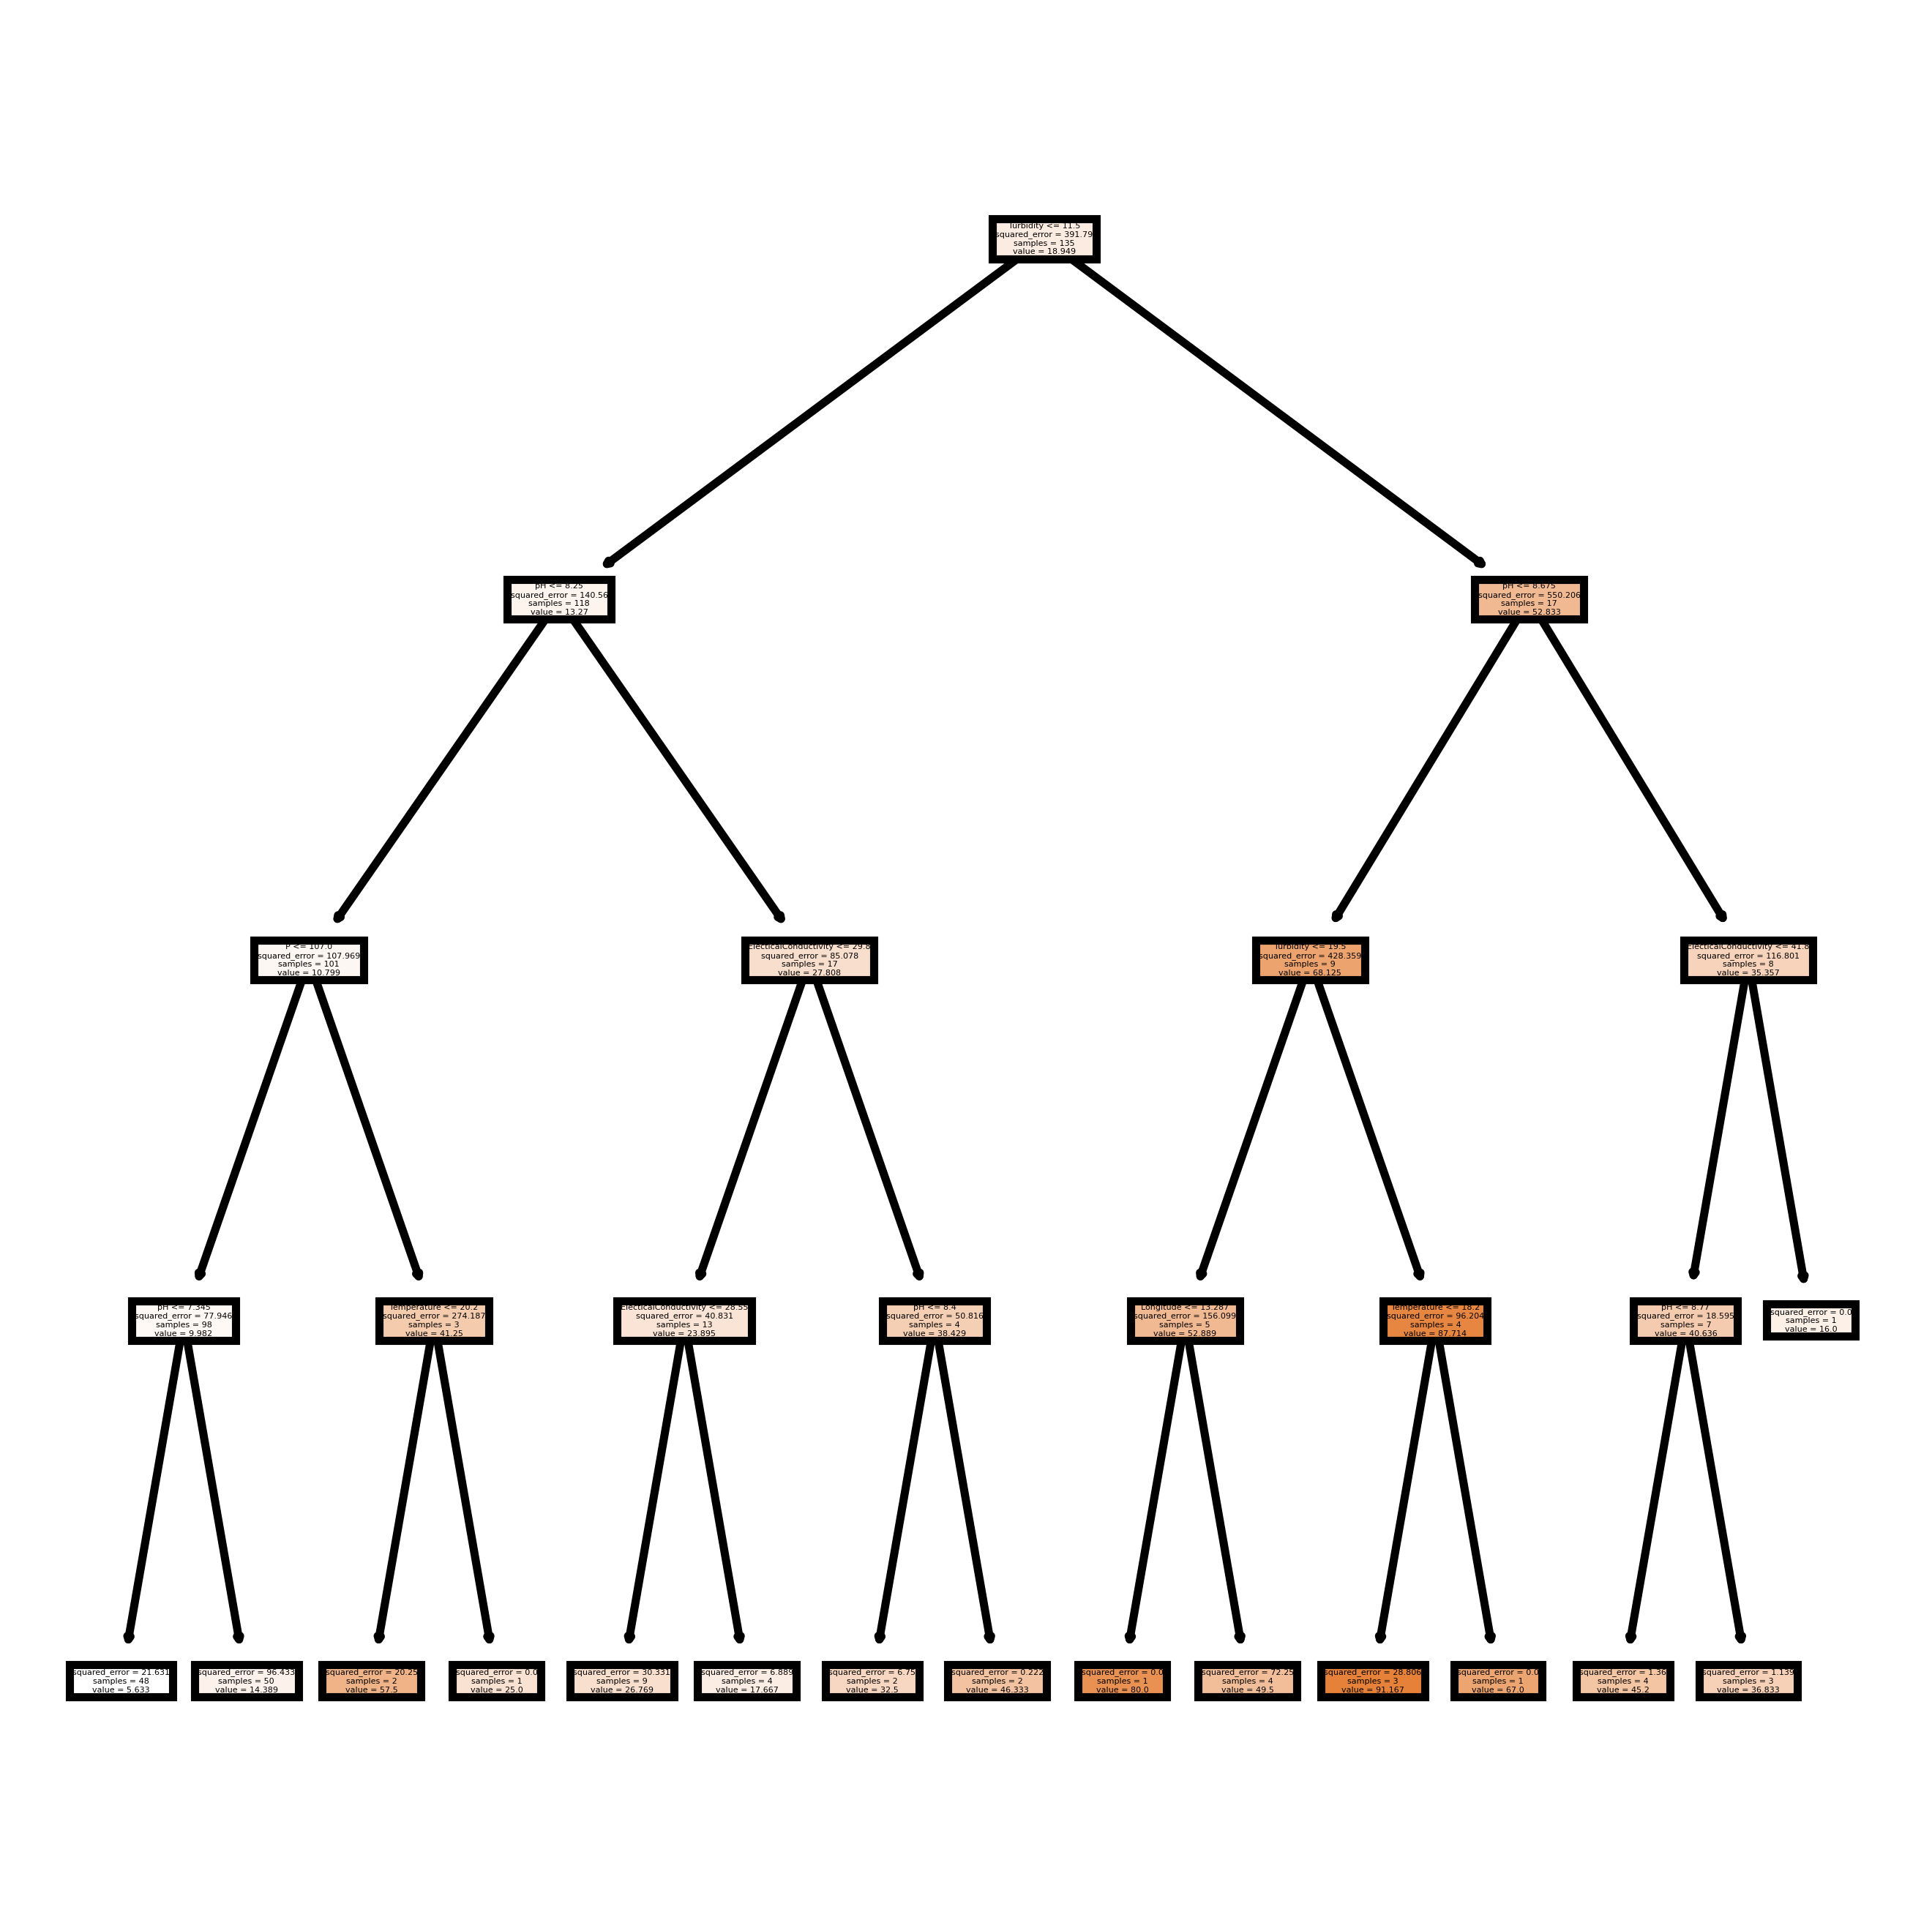

In [18]:
from sklearn import tree
fn=['Date2', 'pH','Latitude','Longitude', 'Temperature', 'P', 'DissolvedOxygen', 'ElecticalConductivity','Turbidity','N']
cn=['Chlorophyll']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(rf.estimators_[0],
               feature_names = fn, 
               class_names=cn,
               filled = True);
fig.savefig('rf_individualtree.png')

In [19]:
# import joblib
# joblib.dump(rf, 'random_forest_model.joblib')


#### Trying XGBoost with hyper parameter tuning

In [20]:
import xgboost as xgb
xgbr = xgb.XGBRegressor()
# Define parameter grid for hyperparameter tuning
param_grid = {
    #'max_depth': [3, 5, 7],
    'max_depth': [7, 9, 11],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.1, 0.01, 0.001]
}

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(xgbr, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, Y_train)
# Print the best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)

# Evaluate the best model on test set
best_xgbr = grid_search.best_estimator_
y_pred = best_xgbr.predict(X_test)
mse = mean_squared_error(Y_test, y_pred)
print("MSE on test set: %.2f" % mse)


KeyboardInterrupt: 

In [ ]:
Y_pred = best_xgbr.predict(X_train )
plt.scatter(Y_train,Y_pred,color='gray', label='predicted')
plt.plot(Y_train,Y_train,color='blue', linewidth=3, label='actual')
plt.plot(Y_train,Y_train*1.1,color='red', linewidth=1.5, label='actual +- 10%')
plt.plot(Y_train,Y_train*0.9,color='red', linewidth=1.5 )
plt.title('Chrlorophyll Predicted vs Actual (Linear Regression)')  
plt.xlabel('Chrlorophyll Actual ')  
plt.ylabel('Chrlorophyll Predicted ')  
plt.legend(loc="upper left")

In [ ]:
Y_pred = best_xgbr.predict(X_test )
plt.scatter(Y_test,Y_pred,color='gray', label='predicted')
plt.plot(Y_test,Y_test,color='blue', linewidth=3, label='actual')
plt.plot(Y_test,Y_test*1.2,color='red', linewidth=1.5, label='actual +- 20%')
plt.plot(Y_test,Y_test*0.8,color='red', linewidth=1.5 )
plt.title('Chrlorophyll Predicted vs Actual (Linear Regression)')  
plt.xlabel('Chrlorophyll Actual ')  
plt.ylabel('Chrlorophyll Predicted ')  
plt.legend(loc="upper left")